# How to Interpolate?

In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py
#import datetime

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation  

In [2]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')

In [3]:
#ROS TIME IS ALREADY WITH REFERENCE FROM EPOCH HENCE NO NEED TO SUBTRACT FROM 1970
def epoch_setup(df):
    #a=dt.datetime.utcfromtimestamp(0)
    #dtx = []
    #converting timestamp to datetime format; subtracting from epoch and converting back to seconds
    #for i in range (len(df.time)):
    #    dtx.append((dt.datetime.fromtimestamp(df.time[i])-a).total_seconds()) 
    #df.insert(1,'epoch',dtx)
    sync_time = df.time-df.time[0]
    df.insert(1,'sync_time',sync_time)
    return df

### Location of Wind Sensor & Source

31.988526614973562


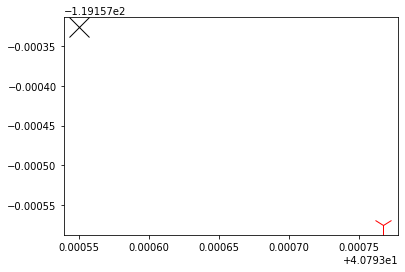

In [4]:
#distance between windstation and odor source
plt.plot([40.79355], [-119.157326], marker='x', markersize=20, color="black")
plt.plot([40.79376709443614], [-119.15757512132207], marker='1', markersize=20, color="red")

#5 inches; 0.127 meters; 12.7 cm

from geopy import distance
coords_1 = (40.79355, -119.157326)
coords_2 = (40.79376709443614, -119.15757512132207)

print (distance.geodesic(coords_1, coords_2).meters)

### Using Rosbag Pandas to import Bag

In [7]:
import rosbag_pandas

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [83]:
filename = '/home/ecc/data/dataOctoberBags/OctoberDesertData/Run02/OctoberDesert1020_0.bag'
df= rosbag_pandas.bag_to_dataframe(filename, exclude=['/imu/data','imu/mag', '/rosout','/rosout_agg','/ublox_gps/fix_velocity', '/ublox_gps/rxmrtcm'],include=['/analog_output', '/trisonica', '/ublox_gps/fix'])

In [84]:
df.columns=df.columns.str.replace(r"/", "_")
sync_time = df.index-df.index[0]

In [85]:
df.insert(0,'sync_time',sync_time)

### Save cleaned bag as H5 

In [87]:
df.to_hdf('~/data/dataOctoberBags/OctoberDesertData/Run02/OctoberDesert1020_0.h5', key='df', mode='w')

/home/ecc/.local/lib/python3.6/site-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['_trisonica_header_frame_id', '_ublox_gps_fix_header_frame_id'], dtype='object')]

  encoding=encoding,


### Load H5

In [5]:
df=pd.read_hdf('~/data/dataOctoberBags/OctoberDesertData/Run02/OctoberDesert1020_0.h5')

### Getting the GPS and WindSensor Time

In [6]:
df["trisonica_time"] = df._trisonica_header_stamp_secs + (df._trisonica_header_stamp_nsecs*1e-9)
df["gps_time"] = df._ublox_gps_fix_header_stamp_secs+(df._ublox_gps_fix_header_stamp_nsecs*1e-9)

In [7]:
df.index[0]  ## checking time resolution

1603221192.5460622

In [8]:
df.keys()    ## checking index headers

Index(['sync_time', '_analog_output_data', '_trisonica_direction',
       '_trisonica_header_frame_id', '_trisonica_header_seq',
       '_trisonica_header_stamp_nsecs', '_trisonica_header_stamp_secs',
       '_trisonica_humidity', '_trisonica_northsouth', '_trisonica_pitch',
       '_trisonica_pressure', '_trisonica_roll', '_trisonica_speed',
       '_trisonica_temperature', '_trisonica_updown', '_trisonica_westeast',
       '_ublox_gps_fix_altitude', '_ublox_gps_fix_header_frame_id',
       '_ublox_gps_fix_header_seq', '_ublox_gps_fix_header_stamp_nsecs',
       '_ublox_gps_fix_header_stamp_secs', '_ublox_gps_fix_latitude',
       '_ublox_gps_fix_longitude', '_ublox_gps_fix_position_covariance_0',
       '_ublox_gps_fix_position_covariance_1',
       '_ublox_gps_fix_position_covariance_2',
       '_ublox_gps_fix_position_covariance_3',
       '_ublox_gps_fix_position_covariance_4',
       '_ublox_gps_fix_position_covariance_5',
       '_ublox_gps_fix_position_covariance_6',
       '_u

### Separating ODOR, WIND, GPS in dataframes

In [28]:
df_odor = pd.DataFrame({'odor_time': df.index,'odor': df._analog_output_data,})
df_wind = pd.DataFrame({'wind_time': df.trisonica_time,'trisonica_U': df._trisonica_westeast,'trisonica_V': df._trisonica_northsouth, })
df_gps = pd.DataFrame({'gps_time': df.gps_time,'lat': df._ublox_gps_fix_latitude,'lon': df._ublox_gps_fix_longitude, })


#### Creating time column for odor by dropping NaNs

In [29]:
df_odor
df_odor = df_odor[df_odor.odor.notna()]
df_odor

,odor_time,odor
1.603221e+09,1.603221e+09,0.636031
1.603221e+09,1.603221e+09,0.635718
1.603221e+09,1.603221e+09,0.634467
1.603221e+09,1.603221e+09,0.636031
1.603221e+09,1.603221e+09,0.635718
...,...,...
1.603221e+09,1.603221e+09,0.589734
1.603221e+09,1.603221e+09,0.592549
1.603221e+09,1.603221e+09,0.593488
1.603221e+09,1.603221e+09,0.592237


### Cominbed time from three sensors and arrange based on time

In [48]:
dfn = pd.concat([df_odor, df_wind, df_gps], sort=True)
combined_time = np.hstack([df_odor.odor_time, df.trisonica_time ,df.gps_time])

In [31]:
dfn['time'] = combined_time
dfn = dfn.sort_values(by=['time'])

In [32]:
dfn

,gps_time,lat,lon,odor,odor_time,trisonica_U,trisonica_V,wind_time,time
1.603221e+09,1.603221e+09,40.793749,-119.157556,NaN,NaN,NaN,NaN,NaN,1.603221e+09
1.603221e+09,1.603221e+09,40.793749,-119.157556,NaN,NaN,NaN,NaN,NaN,1.603221e+09
1.603221e+09,1.603221e+09,40.793749,-119.157556,NaN,NaN,NaN,NaN,NaN,1.603221e+09
1.603221e+09,1.603221e+09,40.793749,-119.157556,NaN,NaN,NaN,NaN,NaN,1.603221e+09
1.603221e+09,1.603221e+09,40.793749,-119.157556,NaN,NaN,NaN,NaN,NaN,1.603221e+09
...,...,...,...,...,...,...,...,...,...
1.603221e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.603221e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.603221e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.603221e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Find Master Time 

In [33]:
dt_odor = np.median(np.diff(dfn.odor_time.dropna().values))
print('dt Odor: ', dt_odor)
dt_wind = np.median(np.diff(dfn.wind_time.dropna().values))
print('dt Wind: ', dt_wind)
dt_gps = np.median(np.diff(dfn.gps_time.dropna().values))
print('dt Gps: ', dt_gps)

dt Odor:  0.00499725341796875
dt Wind:  0.025002002716064453
dt Gps:  0.20000004768371582


In [26]:
first_time = np.max([dfn.odor_time.min(), dfn.wind_time.min(), dfn.gps_time.min()])
last_time = np.min([dfn.odor_time.max(), dfn.wind_time.max(), dfn.gps_time.max()])

In [27]:
master_time = np.arange(first_time, last_time, dt_odor)

### Create Interpolation function

In [37]:
# create interpolation function and inteprolate sensor 1
df_odor_1= dfn[['odor_time', 'odor']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_1.odor_time, df_odor_1.odor)
interp_odor = func_interp_sensor_1(master_time)

In [38]:
df_wind_1= dfn[['wind_time', 'trisonica_U']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1.wind_time, df_wind_1.trisonica_U)
interp_wind_U = func_interp_sensor_1(master_time)

df_wind_2= dfn[['wind_time', 'trisonica_V']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2.wind_time, df_wind_2.trisonica_V)
interp_wind_V = func_interp_sensor_1(master_time)

In [40]:
df_gps_lat= dfn[['gps_time', 'lat']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_lat.gps_time, df_gps_lat.lat)
interp_gps_lat = func_interp_sensor_1(master_time)

df_gps_lon= dfn[['gps_time', 'lon']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_lon.gps_time, df_gps_lon.lon)
interp_gps_lon = func_interp_sensor_1(master_time)

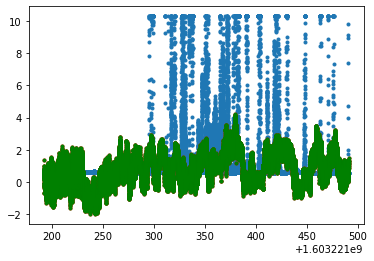

In [41]:
plt.plot(master_time, interp_odor, '.')
plt.plot(master_time, interp_wind_U, '.', color='red')
plt.plot(master_time, interp_wind_U, '.', color='green')

### New Interpolated Dataframe

In [43]:
new_df = pd.DataFrame({'master_time': master_time,
                           'odor': interp_odor,
                           'trisonica_U': interp_wind_U,
                           'trisonica_V': interp_wind_V,
                           'lat': interp_gps_lat,
                           'lon': interp_gps_lon})

In [45]:
new_df

,master_time,odor,trisonica_U,trisonica_V,lat,lon
0,1.603221e+09,0.634854,0.280000,1.160000,40.793749,-119.157556
1,1.603221e+09,0.635494,0.289993,1.160000,40.793749,-119.157556
2,1.603221e+09,0.635827,0.299985,1.160000,40.793749,-119.157556
3,1.603221e+09,0.635718,0.309978,1.160000,40.793749,-119.157556
4,1.603221e+09,0.635305,0.319970,1.160000,40.793749,-119.157556
...,...,...,...,...,...,...
59757,1.603221e+09,0.591438,1.333149,-1.755375,40.793697,-119.157631
59758,1.603221e+09,0.589259,1.496149,-1.733239,40.793697,-119.157631
59759,1.603221e+09,0.589552,1.331477,-1.796238,40.793697,-119.157631
59760,1.603221e+09,0.590273,1.110641,-1.873829,40.793697,-119.157631


### Saving Interpolated Bag

In [46]:
new_df.to_hdf('~/data/dataOctoberBags/OctoberDesertData/Run02/Interpolated_0.h5', key='new_df', mode='w')

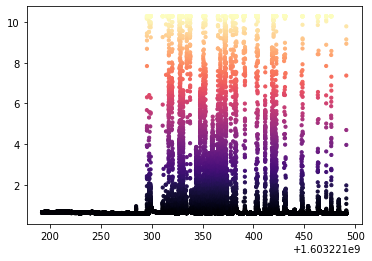

In [47]:
plt.scatter(new_df.master_time,new_df.odor, c=new_df.odor, s=10, cmap='magma')